In [11]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import pyeeg

import matplotlib.pyplot as plt

#Keras

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (StratifiedKFold, KFold)

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

seed=42
np.random.seed(seed)
EPSILON =  0.0002 
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()

In [48]:
def get_train_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path, csv_file)
    print(f"Reading {csv_file}")
    with open(csv_file, 'r') as csvfile:
        train_reader = pd.read_csv(csvfile)
        train_reader.drop(labels="Id", axis=1, inplace=True)
        
        
    return train_reader.values

def get_target_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path,csv_file)
    with open(csv_file, 'r') as csvfile:
        label_reader = pd.read_csv(csvfile)
        #print("Labels: ", label_reader['id'])
        y = label_reader['y']
        
    y = np.array(y)
    return y


def get_features_eeg(X):
    all_featues = []
    # NOT SURE ABOUT THIS VALUES 
    # LETS DOUBLE CHECK
    K_MAX = 6
    SAMPLE_PER_SEC = 32
    FREQ_BANDS = list(range(16))
    TAU = 16
    # embedding dimension
    DE = 32
    
    for i in tqdm(range(X.shape[0])):
        features = list()
        # http://pyeeg.sourceforge.net/
        x_i = X[i,:]
        
        # Power Spectral Intensity (PSI) and Relative Intensity Ratio (RIR)	bin_power()	Two 1-D vectors
        
        
        # Petrosian Fractal Dimension (PFD)	pdf()	A scalar
        features.append(pyeeg.pfd(x_i))
        
        # Higuchi Fractal Dimension (HFD)	hfd()	A scalar
        features.append(pyeeg.hfd(x_i, K_MAX))
        
        # Hjorth mobility and complexity	hjorth()	Two scalars
        
        # Spectral Entropy (Shannon's entropy of RIRs)	spectral_entropy()	A scalar
        #features.append(pyeeg.spectral_entropy(x_i, FREQ_BANDS, SAMPLE_PER_SEC))
        
        # SVD Entropy	svd_entropy()	A scalar
        #features.append(pyeeg.svd_entropy(x_i, TAU, DE))
        
        # Fisher Information	fisher_info()	A scalar
        features.append(pyeeg.fisher_info(x_i, TAU, DE))
          
        # Detrended Fluctuation Analysis (DFA)	dfa()	A scalar
        features.append(pyeeg.dfa(x_i))
        
        # Hurst Exponent (Hurst)	hurst()	A scalar
        #features.append(pyeeg.hurst(x_i))
        
        # AX BASIC FEATUERS
        features.append(np.mean(x_i))
        features.append(np.std(x_i))
        features.append(np.min(x_i))
        features.append(np.max(x_i))
        features.append(np.sum(np.abs(x_i) < 0.001))
        
        
        
        all_featues.append(features)
    return np.array(all_featues)


def get_data_of_rat(X, y, i):
    sample_cnt = int(X.shape[0] / 3)
    if i == 0:
        return X[:sample_cnt, :], y[:sample_cnt]
    if i == 1:
        return X[sample_cnt: 2 * sample_cnt, :], y[sample_cnt: 2 * sample_cnt]
    if i == 2:
        return X[2 * sample_cnt:, :], y[2 * sample_cnt:]

def get_features_emg(X):
    all_featues = []
    for i in tqdm(range(X.shape[0])):
        features = list()
        # https://ieeexplore.ieee.org/document/7748960
        x_i = X[i,:]
        # Root Mean Square (RMS): RMS of EMG
        #features.append(mean_squared_error(x_i, np.zeros(x_i.shape)))
        
        #Integrated Absolute Value (IAV)
        #features.append(np.sum(np.abs(x_i)))
        
        # Mean Absolute Value (MAV): MAV feature can be expressed as
        #features.append(np.mean(x_i))
        
        # TBD:
        # Modified Mean Absolute Value type 1
        # Modified Mean Absolute Value type 2
        
        # Simple Square Integral (SSI): SSI is calculated as
        #features.append(np.sum(x_i ** 2))
        
        # Variance (VAR): VAR is calculated as
        #features.append(np.var(x_i))
        
        #The 3rd, 4th and 5th temporal moments
        #features.append(np.mean(x_i ** 3))
        #features.append(np.mean(x_i ** 4))
        #features.append(np.mean(x_i ** 5))
        
        # TBD
        # v-Order 
        
        # Waveform Length
        #features.append(np.sum(np.abs(np.diff(x_i))))
        
        # Average Amplitude Change
        #features.append(np.mean(np.abs(np.diff(x_i))))
        
        # Difference Absolute Standard Deviation Value
        #features.append(np.sqrt(np.mean(np.power(np.diff(x_i), 2))))
        
        # AX BASIC FEATUERS
        features.append(np.sum(np.abs(x_i) > EPSILON))
        
        
        
        all_featues.append(features)
    return np.array(all_featues)

In [59]:
# compute features
x_train_emg_feat = get_features_emg(x_train_emg)
x_train_eeg_1_feat = get_features_eeg(x_train_eeg_1)
#x_test_emg_feat = get_features_emg(x_test_emg)
#x_test_eeg_1_feat = get_features_eeg(x_test_eeg_1)

In [20]:
x  = SVC()

In [57]:
# CROSS VALDATION
scaler = StandardScaler().fit(x_train_emg_feat)

kfold = KFold(n_splits=3, shuffle=False, random_state=seed)

# classifiers
rf_emg = RandomForestClassifier(n_estimators=5, random_state=seed, n_jobs=-1, verbose=False)

print("Start")
bmac_scores = []

for train, valid in kfold.split(x_train_emg_feat):
    # get the folds
    X_train_fold_emg = x_train_emg_feat[train]
    y_train_fold = y_train[train]
    
    X_valid_fold_emg = x_train_emg_feat[valid]
    y_valid_fold = y_train[valid]

    # get the training for the awake/sleep clf
    awake_fold = X_train_fold_emg[y_train_fold == 1]
    sleep_fold = X_train_fold_emg[y_train_fold != 1]
    X_train_fold_awake_sleep = np.concatenate((awake_fold, sleep_fold))
    y_train_fold_awake_sleep = np.concatenate((np.ones(awake_fold.shape[0], dtype=np.int32), np.zeros(sleep_fold.shape[0], dtype=np.int32)))
    
    awake_fold = X_valid_fold_emg[y_valid_fold == 1]
    sleep_fold = X_valid_fold_emg[y_valid_fold != 1]
    X_valid_fold_awake_sleep = np.concatenate((awake_fold, sleep_fold))
    y_valid_fold_awake_sleep = np.concatenate((np.ones(awake_fold.shape[0], dtype=np.int32), np.zeros(sleep_fold.shape[0], dtype=np.int32)))
    
    # scale 
    #X_train_fold_awake_sleep = scaler.transform(X_train_fold_awake_sleep)
    #X_valid_fold_awake_sleep = scaler.transform(X_valid_fold_awake_sleep)
    
    # fit classifier
    rf_emg.fit(X_train_fold_awake_sleep, y_train_fold_awake_sleep)
    
    y_pred = rf_emg.predict(X_valid_fold_awake_sleep)
    
    bmac_score = balanced_accuracy_score(y_valid_fold_awake_sleep, y_pred)
    print(f"{len(bmac_scores)}: current balanced_accuracy_score: {bmac_score}")

    bmac_scores.append(bmac_score)

print("========================================")
print(f"RFC BMAC avg score {np.mean(bmac_scores)} +/- {np.std(bmac_scores)}" )


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Start
0: current balanced_accuracy_score: 0.9014708913285425
1: current balanced_accuracy_score: 0.9636107703645397
2: current balanced_accuracy_score: 0.9112481304578569
RFC BMAC avg score 0.9254432640503131 +/- 0.027282075983239097


In [60]:
# FINAL PREDICTION
scaler = StandardScaler().fit(x_train_emg_feat)
scaler_eeg = StandardScaler().fit(x_train_eeg_1_feat)

# class weights
classes = np.array([2,3])
weights = compute_class_weight("balanced", classes, y_train_eeg)
cw = dict(zip(classes, weights))

# classifiers
rf_emg = RandomForestClassifier(n_estimators=10, random_state=seed, n_jobs=-1, verbose=False)
rf_eeg = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, class_weight=cw, verbose=False)

# get the training for the awake/sleep clf
awake = x_train_emg_feat[y_train == 1]
sleep = x_train_emg_feat[y_train != 1]
X_train_awake_sleep = np.concatenate((awake, sleep))
y_train_awake_sleep = np.concatenate((np.ones(awake.shape[0], dtype=np.int32), np.zeros(sleep.shape[0], dtype=np.int32)))


# get the training for nrem and rem sleep
nrem = x_train_eeg_1_feat[y_train == 2]
rem = x_train_eeg_1_feat[y_train == 3]
X_train_sleep_type = np.concatenate((nrem, rem))
y_train_sleep_type = np.concatenate((np.ones(nrem.shape[0], dtype=np.int32) * 2, np.ones(rem.shape[0], dtype=np.int32) * 3))

# scale 
X_train_awake_sleep = scaler.transform(X_train_awake_sleep)
X_train_sleep_type = scaler_eeg.transform(X_train_sleep_type)
X_test_emg = scaler.transform(x_test_emg_feat)
X_test_eeg_1 = scaler_eeg.transform(x_test_eeg_1_feat)

# fit classifier
rf_emg.fit(X_train_awake_sleep, y_train_awake_sleep)
rf_eeg.fit(X_train_sleep_type, y_train_sleep_type)

# prediction
y_pred = rf_emg.predict(X_test_emg)

# compute where y_pred is zero 0 => sleep
X_test_eeg_1_sleep = X_test_eeg_1[y_pred == 0]
sleep_index = np.argwhere(y_pred == 0)

# predicted the type of sleep
y_sleep_type = rf_eeg.predict(X_test_eeg_1_sleep)

# compute the final prediction vector
j = 0
for i in sleep_index:
    y_pred[i] = y_sleep_type[j]
    j +=1

/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


NameError: name 'y_train_eeg' is not defined

In [17]:
"""
x_train_emg_feat = get_features_emg(x_train_emg)
x_train_eeg_1_feat = get_features_eeg(x_train_eeg_1)
x_test_emg_feat = get_features_emg(x_test_emg)
x_test_eeg_1_feat = get_features_eeg(x_test_eeg_1)

"""
N_SAMPLES = 5000
random_index = np.random.choice(x_train_eeg_1.shape[0], N_SAMPLES)
x_train_emg_sub = x_train_emg[random_index, :]
y_train_sub = y_train[random_index]
X_transformed = TSNE(n_components=2).fit_transform(x_train_emg_sub)


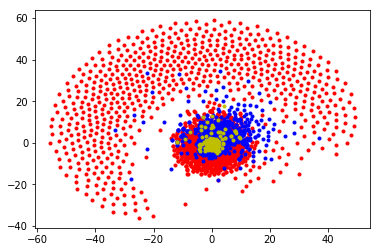

In [18]:
awake_fold = X_transformed[y_train_sub == 1]
nrem_fold = X_transformed[y_train_sub == 2]
rem_fold = X_transformed[y_train_sub == 3]
plt.plot(awake_fold[:,0], awake_fold[:,1], "r.")
plt.plot(nrem_fold[:,0], nrem_fold[:,1], "b.")
plt.plot(rem_fold[:,0], rem_fold[:,1], "y.")
plt.show()

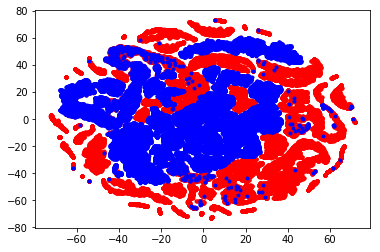

In [7]:
awake_fold = X_transformed[y_train == 1]
sleep_fold = X_transformed[y_train != 1]
plt.plot(awake_fold[:,0], awake_fold[:,1], "r.")
plt.plot(sleep_fold[:,0], sleep_fold[:,1], "b.")
plt.show()

In [124]:
submission_name = "ax_multi_stage.csv"

print(f"Class 1: {np.sum(y_pred == 1)}")
print(f"Class 2: {np.sum(y_pred == 2)}")
print(f"Class 3: {np.sum(y_pred == 3)}")

y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred.shape[0])))
y_pred_df.columns = ['y', 'Id']
display(y_pred_df)


submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)
"""
Class 1: 23933
Class 2: 18553
Class 3: 714
"""

Class 1: 23933
Class 2: 18553
Class 3: 714


,y,Id
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4
5,1,5
6,1,6
7,1,7
8,1,8
9,1,9


'\nClass 1: 23933\nClass 2: 18553\nClass 3: 714\n'